# Udacity Data Analysis Nanodegree
# Project 3: Wrangling and Analyze Data

- [Introduction](#intro)
- [Step 1: Data Gathering](#datagathering)
- [Step 2: Assessing data](#assess)
- [Step 3: Cleaning](#cleaning)
- [Step 4: Storing Data](#storing)
- [Step 5: Analysing and Visualization](#visuals)
- [References](#references)
- [Submission](#submission)

<a id='intro'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Introduction</span>

This project was completed as part of the 'Data Analyst' nanodegree with Udacity. 

The goal of the project was to demonstrate the data wrangling and analysis skills obtained from the course.

The dataset to be wrangled is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. Dog owners upload a picture of their dog, writes a funny comment and give their own dog a rating out of 10. Owners almost always give their dogs a rating greater than 10. e.g 11/10, 12/10, 13/10, it's the nature of the website. WeRateDogs has over 4 million followers and has received international media coverage. It's only a bit of fun, and brings great joy when browsing the cutest dog images !

In [ ]:
import json
import os
import time
from io import BytesIO

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import tweepy
from IPython.display import HTML, display
from PIL import Image

# import custom functions that generate visualizations for repetitive code
from src.utils import *

# magic word for producing visualizations in notebook
%matplotlib inline

# suppress matplotlib user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

# environment settings
pd.set_option('display.max_colwidth', None)

# stock scientific notation on graphs
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
# Default parameters

# general data directory
filename_general = '../data'

# twitter archive
filename_twitter_archive = '../data/twitter_archive_enhanced.csv'

# image predictions
folder_image_predictions = '../data/image_predictions'
filename_image_predictions = '../data/image_predictions/image_predictions.tsv'

# additional data from twitter API 
folder_twitter_api = '../data/json'
filename_twitter_api = '../data/json/tweet_json.txt'
filename_twitter_api_output = '../data/tweepy_api.csv'
filename_twitter_api_errors = '../data/tweepy_api_errors.txt'

# dog posters
folder_image_profiles = '../data/image_profiles'
filename_image_errors = '../data/json/api_missing_data_errors.txt'

<a id='datagathering'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 1: Data Gathering</span>


In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.

<span style="color:blue">1.1 Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)</span>

In [ ]:
# Download file from Udacity server
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv'
df_twitter_archive = pd.read_csv(url)
df_twitter_archive.head()

In [ ]:
df_twitter_archive.shape

In [ ]:
# write WeRateDogs Twitter archive data to csv

# Make main data directory if it doesn't already exist
create_folder(filename_general)

df_twitter_archive.to_csv(filename_twitter_archive, index=False)

<span style="color:blue">1.2 Use the Requests library to download each tweet's image prediction (image_predictions.tsv)</span>

In [ ]:
# Make directory if it doesn't already exist
create_folder(folder_image_predictions)

In [ ]:
# download and save image predictions
udacity_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(udacity_url)  

# save file 
with open(filename_image_predictions, mode = 'wb') as file:
    file.write(response.content)

Test if file was downloaded from Udacity server successfully

In [ ]:
# check that a file was saved in the new directory
assert len(os.listdir(folder_image_predictions)) == 1

In [ ]:
# load new file into a dataframe
df_image_predictions = pd.read_csv(filename_image_predictions, sep='\t')

Test if file was loaded into a dataframe successfully

In [ ]:
df_image_predictions.head()

In [ ]:
df_image_predictions.shape

<span style="color:blue">1.3 Use twitter API 'tweepy' to retrieve additional data</span>

For each twitter id in the twitter archive file from step 1.1, retrieve additional data from the API
Minimum requirement: retweet count, and favorite count

In [ ]:
# import API credentials from environment variables
consumer_key = os.environ.get('TWITTER_CONSUMER_KEY')
consumer_secret = os.environ.get('TWITTER_CONSUMER_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_secret = os.environ.get('TWITTER_ACCESS_SECRET')
bearer_token = os.environ.get('TWITTER_BEARER_TOKEN')

In [ ]:
# download and save files

start_time = time.time()

# create a folder if it does not exist
create_folder(folder_twitter_api)
error_list = []
counter = 1
total_records = df_twitter_archive['tweet_id'].shape[0]

# Make a connection with API v2
client = tweepy.Client( bearer_token=bearer_token, 
                        consumer_key=consumer_key, 
                        consumer_secret=consumer_secret, 
                        access_token=access_token, 
                        access_token_secret=access_secret, 
                        return_type = requests.Response,
                        wait_on_rate_limit=True)

# write json file
with open(filename_twitter_api, 'w') as outfile:

    for tweet_id in df_twitter_archive['tweet_id']:

            # This cell is slow so print counter to gauge time remaining   
            if counter%50 == 0:
                print('Tweet: {}, {} out of {} tweets completed'.format(tweet_id, counter, total_records))

            # call get_tweets API
            tweet_fields = ["public_metrics", "entities", "text", "attachments","geo"]
            expansions = ['geo.place_id', 'attachments.media_keys']
            media_fields = ['url', 'type']
            place_fields = ['country_code', 'full_name', 'place_type']
            response = client.get_tweets(tweet_id, 
                                         tweet_fields=tweet_fields, 
                                         expansions=expansions,
                                         media_fields=media_fields,
                                         place_fields = place_fields)
            if response.status_code == 200:        
                # write tweet to file on its own line
                json_string = json.dumps(response.json()) 
                outfile.write(json_string + '\n')

            else:
                # construct error message and append to error list
                error_message = "Request returned an error: {} {}".format(response.status_code, response.text)
                print(error_message)
                error_list.append(error_message)
                
            counter+=1
            
end_time = time.time()
print('Executing time: {}'.format(end_time - start_time))

In [ ]:
# create .txt file containing API errors
if len(error_list) > 0:
    with open('../data/json/api_errors.txt', 'w') as outfile:
        outfile.write(str(error_list))

In [ ]:
# read json file and import into a dataframe

selected_attr = []
error_list = []
counter=0

with open(filename_twitter_api, 'r') as json_file:
    for line in json_file:

        json_data = json.loads(line)
        
        # Extract "data" value from dictionary
        try:
            tweets_data = json_data['data'][0] 
            tweet_id = tweets_data['id']
            text = tweets_data['text']            
        except:
            message = ('Error for index {}: [data] not available could be tweet no longer exist'.format(counter))
            error_list.append(message)
            continue
        
        # get first image of dog
        try: 
            tweets_media = json_data['includes'] 
            media_url = tweets_media['media'][0]['url']
            media_type = tweets_media['media'][0]['type']  
        except:
            media_url = media_type = ''
            message = 'Error for index {}: media not available for tweet {}'.format(counter, tweet_id)
            error_list.append(message)

        # get public statistics e.g. retweet and like data
        try:
            retweet_count = tweets_data['public_metrics']['retweet_count']
            reply_count = tweets_data['public_metrics']['reply_count']
            like_count = tweets_data['public_metrics']['like_count']
            quote_count = tweets_data['public_metrics']['quote_count']   
        except:
            retweet_count = reply_count = like_count = quote_count = ''  
            message = ('Error for index {}: public statistics not available for tweet {}'.format(counter, tweet_id))   
            error_list.append(message)
                       
        # get first available urls
        try:
            short_url = tweets_data['entities']['urls'][0]['url']                              
            expanded_url = tweets_data['entities']['urls'][0]['expanded_url']    
        except:
            short_url = expanded_url = ''        
            message = ('Error for index {}: URL not available for tweet {}'.format(counter, tweet_id))   
            error_list.append(message)            
            
        
        # get first annotation to possibly pick up the name of the dog, if it exists
        try:
            annotation = tweets_data['entities']['annotations'][0]['normalized_text'] 
        except:
            annotation = ''
            message = ('Error for index {}: Annotations not available for tweet {}'.format(counter, tweet_id)) 
            error_list.append(message)      

            
        selected_attr.append({"id": tweet_id,
                              "text": text,
                              "retweet_count": retweet_count,
                              "reply_count":  reply_count,
                              "like_count": like_count,
                              "quote_count": quote_count,
                              "media_url": media_url,
                              "media_type": media_type,                  
                              "short_url": short_url ,                      
                              "expanded_url": expanded_url,
                              "annotation": annotation
                             })
            
        counter+=1

In [ ]:
#create dataframe
df_tweepy = pd.DataFrame(selected_attr)
df_tweepy.head()

In [ ]:
# create .txt file containing missing data problems we could not retrieve from the dumped json data
if len(error_list) > 0:
    with open(filename_twitter_api_errors, 'w') as outfile:
        outfile.write(str(error_list))

In [ ]:
df_tweepy.to_csv('../data/tweepy_api.csv', index=False)

<span style="color:blue">1.4 Download dog profile images (optional extra step)</span>

In [ ]:
df_tweepy = pd.read_csv(filename_twitter_api_output)
df_tweepy.head(5)            

In [ ]:
# retrieve dog posters

start_time = time.time()

df_list = []
image_errors = []
counter = 0
total_records = df_tweepy.shape[0]

  
# Make directory if it doesn't already exist
create_folder(folder_image_profiles)    

# Download images
for i in df_tweepy.index:
    
    url = df_tweepy['media_url'][i]
    tweet_id = df_tweepy['id'][i]
    
    if url:
        try:
            # Download movie poster image
            r = requests.get(url)
            i = Image.open(BytesIO(r.content))
            # file format of images, e.g. jpg
            image_file_format = url.split('.')[-1]
            i.save(folder_image_profiles + "/" + str(tweet_id) + "." + image_file_format)

        except Exception as e:
            error_message = (str(counter) + "_" + str(tweet_id) + ": " + str(e))
            image_errors.append(error_message)              
            
  # This cell is slow so print progress to gauge time remaining
    counter+=1 
    if counter%100 == 0:
        print('Tweet: {}, {} out of {} images downloaded'.format(tweet_id, counter, total_records))            
            
end_time = time.time()
print('Executing time: {}'.format(end_time - start_time))

In [ ]:
# create .txt file containing missing data problems we could not retrieve from the dumped json data
if len(image_errors) > 0:
    with open(filename_image_errors, 'w') as outfile:
        outfile.write(str(image_errors))
        
print('Whilst downloading images, {} errors occurred'.format(len(image_errors)))

<a id='assess'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 2: Assessing Data</span>

##### Project criteria: 

In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. Use **both** visual and programmatic assessment to assess the data.

**Note:** pay attention to the following key points when assessing the data:

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.


Index:

- [Step 2.1: Assess twitter archive data](#twitter_archive)
- [Step 2.2: Assess twitter API data](#twitter_api)
- [Step 2.3: Assess twitter breed prediction data](#twitter_predictions)

<a id='twitter_archive'></a>
<span style="color:blue; font-size:16px">2.1 Assess twitter archive data</span>

In [ ]:
# read twitter_archive table and do visual assessment of a sample
df_twitter_archive = pd.read_csv(filename_twitter_archive)
df_twitter_archive.sample(20)

**Observations from visual inspection**:
- columns related to retweet and replies (`in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, etweeted_status_user_id, retweeted_status_timestamp`) have a lot of missing values and indicate not a lot of retweets occur
- `source` contain multiple information (url, source)
- `text` contain multiple sets of information (text, rating and url)
- `name`: lots of values with 'None' indicating missing data
- `name`: contains invalid data like 'a'
- `doggo, floofer, pupper, puppo` : contains lots of 'None', values indicating missing values. Columns describe the stage/age of a dog
- `expanded_urls` contains more than one url sometimes, example tweet id 853299958564483072

In [ ]:
# which datatypes does the dataset have, and how many missing values can be observed ?
df_twitter_archive.info()

**Observation from programming inspection `info()`:**

- Dataset have 2356 rows and 17 columns. 
- The following columns related to retweets and replies have more than 90% missing data:
    - in_reply_to_status_id  
    - in_reply_to_user_id 
    - retweeted_status_id
    - retweeted_status_user_id 
    - retweeted_status_timestamp 

In [ ]:
# how many unique values does each column of the dataset have ?
df_twitter_archive.nunique()

**Observation from programming inspection `nunique()`:**
    
- columns related to retweets (`in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp`): have < 200 unique values indicating we have very little retweets and replies in general
- `expanded_urls`: contain 2297 non-null entries and yet have 2218 unique values, which indicate duplicates exist
- `name`: only 957 unique values exist for 2356 dogs, meaning lots of dogs have the same name and/or lots of missing values exist
- `doggo, floofer, pupper, puppo` : contains only 2 possible values indicating these might be binary fields related to the stage/age of a dog

In [ ]:
# show unique values for some columns
print('\nUNIQUE VALUES FOR COLUMNS: \n')
cols = ['source', 'text', 'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']
for col in cols:
    print('Unique values for column {}: \n {} \n'.format(col, df_twitter_archive[col].sort_values().unique()))

**Observation from programming inspection `unique()`:**
- `source` contain multiple pieces of information: url and source
- `doggo, floofer, pupper, puppo` contain string values 'None' which indicate missing data
- `text` contains multiple information: text, score and url
- `name` starting with lower case are not valid dog names e.g. 'the, 'actually', 'this', 'one'
- `rating_denominator` contains values that are not equal to 10

In [ ]:
# denominator contains values that are not equal to 10, lets futher explore these entries
df_twitter_archive[df_twitter_archive['rating_denominator'] != 10]

In [ ]:
# how many records do we have that a denominator <> 10
len(df_twitter_archive[df_twitter_archive['rating_denominator'] != 10])

**Observation from programming inspection `rating_denominator`**:

- We have only 23 records where the denominator is not equal to 10
- In most cases (but not all), it was caused by incorrect extraction from the text field where multiple rating patterns exist, of which the first one was extracted.

As it's only 23 records, I would suggest we drop these records to have a clean analysis

In [ ]:
# show value counts for some problematic columns
print('\nUNIQUE VALUES FOR COLUMNS: \n')
cols = ['source', 'rating_numerator', 'rating_denominator', 'doggo', 'floofer', 'pupper', 'puppo']
for col in cols:
    print('Unique values for column {}: \n {} \n'.format(col, df_twitter_archive[col].value_counts()))

**Observation from programming inspection `value_counts`:**
    
- rating_denominator = 10 is used most of the time, the rest looks like exceptional errors
- not a lot of values seems to be present for the dog stage related columns overall, we have lots of values = 'None'. Maybe not all dog stages were extracted ?

#### Duplicate checks

In [ ]:
# Are any rows duplicated ?
df_twitter_archive.duplicated().sum()

In [ ]:
# how many duplicated `expanded_urls` exist ?
df_twitter_archive['expanded_urls'].dropna().duplicated().sum()

In [ ]:
# display some duplicated `expanded_urls`
df_twitter_archive[df_twitter_archive['expanded_urls'].duplicated(keep=False)].sort_values(by='expanded_urls')

In [ ]:
# confirm retweeted_status_id is the link to original tweet_id in case of retweets
original_tweets = pd.DataFrame(df_twitter_archive['tweet_id'].astype(int).values.tolist())
retweets = pd.DataFrame(df_twitter_archive['retweeted_status_id'].dropna().astype(int).values.tolist())
common_elements = np.intersect1d(original_tweets, retweets)
len(common_elements)

In [ ]:
# confirm in_reply_to_status_id is the link to original tweet_id in case of replies
replies = pd.DataFrame(df_twitter_archive['in_reply_to_status_id'].dropna().astype(int).values.tolist())
common_elements = np.intersect1d(original_tweets, replies)
len(common_elements)

**Observation of duplications:**

- duplicated `expanded_urls` seems mostly related to retweets. 
- `retweeted_status_id` and `in_reply_to_status_id` are links to original tweet_ids and can be used to identify tweets that are not original posts.

In [ ]:
# Do we have any records prior Aug 1st, 2017 ?
len(df_twitter_archive[df_twitter_archive['timestamp'].astype('datetime64[ns]').dt.strftime('%Y-%m-%d') > '2017-08-01'])

<a id='twitter_api'></a>
<span style="color:blue; font-size:16px">2.2 Assess twitter API data</span>

In [ ]:
# visual inspection of Twitter api data
df_tweepy = pd.read_csv(filename_twitter_api_output)
df_tweepy.sample(20)

In [ ]:
df_tweepy.info()

In [ ]:
df_tweepy.nunique()

**Observations:**
- missing records: 2326 records exist vs 2356 records in the master archive table in 2.1
- expanded_url contains the same information as df_twitter_archive.expanded_url
- short_url is the same URL that is contained inside df_twitter_archive.text
- annotation contains mostly either the name of the dog, breed, or some location. A lot of NaN records exist

<a id='twitter_predictions'></a>
<span style="color:blue; font-size:16px">2.3 Assess twitter breed predictions</span>

In [ ]:
# visual inspection of twitter predictions
df_twitter_predictions = pd.read_csv(filename_image_predictions, sep='\t')
df_twitter_predictions.sample(20)

In [ ]:
df_twitter_predictions.info()

In [ ]:
df_twitter_predictions.nunique()

In [ ]:
df_twitter_predictions.duplicated().sum()

In [ ]:
# how many duplicated tweet ids exist ?
df_twitter_predictions['tweet_id'].dropna().duplicated().sum()

**Observations:**
- `df_twitter_predictions` contain only 2075 records, whilst df_twitter_archive contain 2356 records. Means some records are missing, not all dogs have breed predictions.
- 3 different dog breed predictions exist for each dog, of which we need to select the best breed.
- breed name can be formatted better. Remove '_' and capitalize each word.

## Summary of assessment

### Quality issues
Do we have all the records that we should? Do we have missing records or not? Are there specific rows, columns, or cells missing?

<blockquote>
    
#### Completeness Issues (e.g. missing data)

1. twitter_archive: Replies to original tweets exist causing duplicate tweets

2. twitter_archive: Retweets exist causing duplicate tweets

3. twitter_archive: `name` contains string value 'None' indicating missing data

4. twitter_archive: Columns `doggo, floofer, pupper, puppo` contain value 'None' indicating missing data

5. twitter_archive: some `expanded_urls` are duplicated (it might be because of retweets and replies)
    
6.  Columns exist with 90% missing data: `in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp`


#### Validity Issues (incorrect entries, data types)

7. twitter_archive: 23 records (prior start of cleaning) have ratings_denominator values other than 10
8. twitter_archive: `expanded_urls` contains more than one url sometimes, example tweet id 853299958564483072
9. `timestamp` should be type datetime    


#### Accuracy Issues

10. twitter_archive: `name` starting with lower case are not valid dog names e.g. 'the, 'actually', 'this', 'one'


#### Consistency

11. twitter_api: 'id' column should be called 'tweet_id' to be consistent with twitter_archive table.
  
</blockquote>

### Tidiness issues

<blockquote>
    
#### Twitter archive table:

1. `source` contain multiple pieces of information: url and source

2. `text` contains multiple information: text, score and url
  
3. The dog stage is one variable and hence should form a single column. But this variable is spread across 4 columns - doggo, floofer, pupper, puppo

#### `twitter_api` table:

4. Information about tweets is spread across three different files/dataframes

#### Twitter predictions table:

5.  Information about tweets is spread across three different files/dataframes
6.  Breed name are badly formatted, it contains '_' instead of spaces and each word can be capitalized.
</blockquote>

<a id='cleaning'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 3: Cleaning Data</span>


#### Project criteria

In this section, clean **all** the issues you documented while assessing.

Make sure you complete the following items in this step.

Before you perform the cleaning, you will make a copy of the original data.
During cleaning, use the define-code-test framework and clearly document it.
Cleaning includes merging individual pieces of data according to the rules of tidy data. The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [ ]:
# Make copies of original pieces of data
df_twitter_archive_clean = df_twitter_archive.copy() 
df_tweepy_clean = df_tweepy.copy()
df_twitter_predictions_clean = df_twitter_predictions.copy()

<span style="color:blue; font-size:22px; line-height:40px; font-family: Calibri;">Quality Issues</span>

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #1: twitter_archive : replies to original tweets exist causing duplicate tweets</span>

#### Define: Filter the dataset where 'in_reply_to_status_id' `isnull()`

#### Code

In [ ]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['in_reply_to_status_id'].isnull()]

#### Test

In [ ]:
# no records should exist where in_reply_to_status_id have values
assert len(df_twitter_archive_clean[~df_twitter_archive_clean['in_reply_to_status_id'].isnull()]) == 0

<span style="color:blue; font-size:18px; font-family: Calibri;"> Quality Issue #2: twitter_archive : retweets exist in the dataset causing duplicate postings</span>

#### Define: Filter the dataset where 'in_reply_to_status_id' `isnull()`

#### Code

In [ ]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['retweeted_status_id'].isnull()]

#### Test

In [ ]:
# no records should exist where retweeted_status_id is populated
assert len(df_twitter_archive_clean[~df_twitter_archive_clean['retweeted_status_id'].isnull()]) == 0

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #3: twitter_archive : 'name' contains string value 'None' indicating missing data</span>

#### Define: Convert string value 'None' to None in column 'name' using pandas `replace()` method, to correctly identify missing names

#### Code

In [ ]:
df_twitter_archive_clean['name'] = df_twitter_archive_clean['name'].replace('None', None)

#### Test

In [ ]:
# how many records exist where dog name is 'None' ?
assert len(df_twitter_archive_clean.query('name == "None"')) == 0

In [ ]:
# can we now identify missing records in the name field correctly?
df_twitter_archive_clean.name.info()

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #4: twitter_archive: Columns 'doggo', 'floofer', 'pupper' and 'puppo' contain value 'None' indicating missing data</span>

#### Define: Convert string value 'None' to np.nan in columns doggo, floofer, pupper and puppo using pandas `replace()` method.

#### Code

In [ ]:
cols = ['doggo', 'floofer', 'pupper', 'puppo']
df_twitter_archive_clean[cols] = df_twitter_archive_clean[cols].replace('None', None)

#### Test

In [ ]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('doggo == "None"')) == 0

In [ ]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('floofer == "None"')) == 0

In [ ]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('pupper == "None"')) == 0

In [ ]:
# No more "None" values should exist
assert len(df_twitter_archive_clean.query('puppo == "None"')) == 0

In [ ]:
# All None values should be replaced with None
df_twitter_archive_clean.doggo.value_counts(dropna=False)

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #5: twitter_archive: some expanded_urls are duplicated (it might be because of retweets and replies)</span>

#### Define: Drop records with duplicate `expanded_urls`, by first sorting the dataset by 'expanded_urls' and then use pandas `duplicated` method, keeping the first record, as this is the original tweet.

#### Code

In [ ]:
# sort table by tweet_id, as we want keep the records with first posting
df_twitter_archive_clean.sort_values('tweet_id', axis=0, inplace=True)

In [ ]:
# number of records before we start
records_before = df_twitter_archive_clean.shape[0]
records_before

In [ ]:
# display the duplicated `expanded_urls` to double-check their existence after some records in
# issue 1 and 2 were dropped
df_twitter_archive_clean[df_twitter_archive_clean['expanded_urls'].duplicated(keep=False)].sort_values(by='expanded_urls')

**Observation:**

Only 1 duplicate still remain after we dropped retweets and replies. We should not drop rows with NaN values

In [ ]:
# remove the 1 duplicate that still exist
df_twitter_archive_clean = df_twitter_archive_clean[(~df_twitter_archive_clean['expanded_urls'].duplicated(keep='first')) | (df_twitter_archive_clean['expanded_urls'].isnull())]

#### Test

In [ ]:
# only 1 record should be dropped
assert (records_before - df_twitter_archive_clean.shape[0]) == 1

In [ ]:
# Make sure we kept the first tweet_id
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] == 668587383441514497]

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #6:  Columns exist with 90% missing data: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp</span>

#### Define: drop columns no longer needed after retweets and replies are removed. Columns to drop: in_reply_to_status_id	in_reply_to_user_id, retweeted_status_id	retweeted_status_user_id, retweeted_status_timestamp

#### Code

In [ ]:
cols_to_drop = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                'retweeted_status_user_id', 'retweeted_status_timestamp']

In [ ]:
df_twitter_archive_clean.drop(cols_to_drop, axis=1, inplace=True)

#### Test

In [ ]:
# check that all columns dropped no longer exist in the dataset
assert (cols_to_drop in df_twitter_archive_clean.columns.tolist()) == False

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #7: twitter_archive: 23 records (prior start of cleaning) have ratings_denominator values other than 10</span>

#### Define: Filter the dataset where `ratings_demominator` == 10

## Code

In [ ]:
# Take snapshot of number of records before
records_before = df_twitter_archive_clean.shape[0]

In [ ]:
df_twitter_archive_clean = df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] == 10]

#### Test

In [ ]:
records_after = df_twitter_archive_clean.shape[0]
print('Number of records dropped: {}'.format(records_before - records_after))

In [ ]:
# 'rating_denomitor' should only have the value 10
assert len(df_twitter_archive_clean[df_twitter_archive_clean['rating_denominator'] != 10]) == 0

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #8: twitter_archive: expanded_urls contains more than one url sometimes (e.g. tweet id 853299958564483072)</span>

#### Define: Split expanded_urls column using pandas `str.split()` method with ',' as delimiter and take the first entry. 

#### Code

In [ ]:
# display example tweet prior cleaning
df_twitter_archive_clean.query('tweet_id == 853299958564483072')

In [ ]:
df_twitter_archive_clean['expanded_urls'] = df_twitter_archive_clean['expanded_urls'].str.split(',').str[0]

#### Test

In [ ]:
# display example tweet after cleaning
df_twitter_archive_clean.query('tweet_id == 853299958564483072')

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #9: timestamp should be type datetime</span>

#### Define: convert timestamp from type string to datetime using pandas `to_datetime` method.  Only keep the date part of the timestamp and drop the time.

#### Code

In [ ]:
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp']).dt.date.astype('datetime64[ns]')

#### Test

In [ ]:
assert df_twitter_archive_clean.timestamp.dtype.name == 'datetime64[ns]'

In [ ]:
# timestamp should now contain only a date without time
df_twitter_archive_clean.timestamp.sample(10)

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #10: twitter_archive: name starting with lower case are not valid dog names e.g. 'the, 'actually', 'this', 'one'</span>

#### Code

In [ ]:
# How many dog names do we have with np.nan ?
nan_before = df_twitter_archive_clean['name'].isna().sum()
print('Number of records where dog name contain np.nan: {}'.format(nan_before))

In [ ]:
# create a new column with flag if dog name only contains lower case characters
df_twitter_archive_clean['lower'] = df_twitter_archive_clean['name'].str.islower()
lowercase_records = len(df_twitter_archive_clean[df_twitter_archive_clean['lower'] == True])
print('Number of records with only lower case dog names: {}'.format(lowercase_records))

In [ ]:
# change dog name with only lower case values to nan
df_twitter_archive_clean.loc[df_twitter_archive_clean['lower'] == True, 'name'] = np.nan

In [ ]:
# drop temp column 'lower'
df_twitter_archive_clean.drop(['lower'], axis=1, inplace=True)

#### Test

In [ ]:
# We expect to have 101 more records where dog name = np.nan
assert (nan_before + lowercase_records) == df_twitter_archive_clean['name'].isna().sum()

<span style="color:blue; font-size:18px; font-family: Calibri;">Quality Issue #11: twitter_api: 'id' column should be called 'tweet_id' to be consistent with twitter_archive table</span>

#### Define: rename column 'id' to 'tweet_id' using pandas `rename()` method

#### Code

In [ ]:
df_tweepy_clean.rename({'id': 'tweet_id'}, axis=1, inplace=True)

#### Test

In [ ]:
# check that first column name is now 'tweet_id'
assert df_tweepy_clean.columns[0] == 'tweet_id'

<a id='tidiness'></a>
<span style="color:blue; font-size:25px; line-height:40px; font-family: Calibri;">Tidiness issues</span>

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #1: source contain multiple pieces of information: url and source</span>

#### Define: keep only the source part of the text, by using `str.split` statement using '>' as a delimiter. Keep all the text after the delimiter.

#### Code

In [ ]:
# inspect unique entries before clean-up
df_twitter_archive_clean['source'].unique()

In [ ]:
df_twitter_archive_clean['source'] = df_twitter_archive_clean.source.str.split(">").str[-2].str.replace('</a', '')

#### Test

In [ ]:
# inspect unique entries after clean-up, it should now only contain the source
df_twitter_archive_clean['source'].unique()

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #2: text contains multiple information: text, score and url</span>

#### Define: Create a new column 'cleantext', by remove the score and url from the original text field, using regex expressions. First remove the URL, then remove all text after the score pattern, dropping temporary fields that are needed as last step.

#### Code

In [ ]:
# first remove the URL pattern
df_twitter_archive_clean['tmptext'] = df_twitter_archive_clean['text'].str.split('https:\/\/.*').str[0].str.rstrip()

In [ ]:
# second remove all text after the score pattern
df_twitter_archive_clean['cleantext'] = df_twitter_archive_clean['tmptext'].str.split('\d+/\d+').str[0]

# drop tempory fields no longer needed
df_twitter_archive_clean.drop(['tmptext'], axis=1, inplace=True)

#### Test

In [ ]:
df_twitter_archive_clean[['text', 'cleantext']].sample(10)

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #3: The dog stage is one variable and hence should form a single column. But this variable is spread across 4 columns - doggo, floofer, pupper, puppo</span>

#### Define: 
Consolidate the different dog stage columns into one column by using the pandas `melt` and `rename` methods. Drop the 'variable' column as it's not needed. 

In addition, rebuild dog stages from the original 'text' column, using regex `extract()` to attempt to reduce NaN values. 

Build a new dog stage feature combining the values of 2 approaches above. Use the original dog stage as the base, but fill NaN values with values from dog stages build from text, using pandas `fillna` method

Drop the dog stage build from text, as it's no longer needed as it's merged into one consolidated column
Drop the original text as it's no longer needed

#### Code

In [ ]:
# We need to make sure records before and after melt are the same later on. Take a before snapshot
records_before = df_twitter_archive_clean.shape[0]
print('`df_twitter_archive_clean` records before `melt` statement: {}'.format(records_before))

In [ ]:
# using one tweet as test, lets capture it's before values
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] == 696518437233913856]

###### Step 1: Merge dog stages into a single field

In [ ]:
# Extract dog_stage information in seperate dataframe
dog_stage = df_twitter_archive_clean.filter(['tweet_id', 'floofer', 'pupper', 'doggo', 'puppo'], 
                                            axis = 1).copy()

# Consolidate different dog stages into one column 
dog_stage = pd.melt(dog_stage, 
                    id_vars = ['tweet_id'], 
                    value_vars = ['floofer', 'doggo', 'pupper', 'puppo'], 
                    value_name="dog_stage")

dog_stage.drop('variable', axis = 1, inplace = True)

# #Delete rows with Dog_stage "NaN" as well as records with more than one dog stage
dog_stage.drop(dog_stage.query('dog_stage != dog_stage').index, axis = 0, inplace = True)
dog_stage.drop_duplicates(subset = 'tweet_id', keep = False, inplace = True)

In [ ]:
# Merge manipulated dataset with df_twitter_clean and delete all other dog stage columns
df_twitter_archive_clean = pd.merge(df_twitter_archive_clean, dog_stage,on = ['tweet_id'], how = 'left')
df_twitter_archive_clean.drop(['floofer', 'pupper', 'doggo', 'puppo'], axis = 1, inplace = True)
# Write all category names lower key
df_twitter_archive_clean.dog_stage = df_twitter_archive_clean.dog_stage.str.lower()

###### Step 2: Rebuild dog stages from the text

In [ ]:
# rebuild dog stages from the text
df_twitter_archive_clean['dog_stage_text'] = df_twitter_archive_clean['text'].str.extract('([Pp]uppo|[Pp]upper|[Ff]loofer|[Dd]oggo|[Bb]lep)', expand=True)

# convert to lower case
df_twitter_archive_clean.dog_stage_text = df_twitter_archive_clean.dog_stage_text.str.lower()

###### Step 3: Build a new dog_stage column consisting of a combination of above 2 approaches.
Use the orginal dog stage as the base, but fill NaN values with values from dog stages build from text

In [ ]:
df_twitter_archive_clean['dog_stage'] = df_twitter_archive_clean['dog_stage'].fillna(df_twitter_archive_clean['dog_stage_text'])

#### Test

In [ ]:
records_after = df_twitter_archive_clean.shape[0]
assert records_before == records_after

In [ ]:
# make sure all NaN entries from combined dog stage column that could be filled from text are now filled
assert len(df_twitter_archive_clean.query('(dog_stage.isnull()) & (~dog_stage_text.isnull())')) == 0

In [ ]:
df_twitter_archive_clean.drop(['dog_stage_text', 'text'], axis=1, inplace=True)

In [ ]:
# how many None values now exist after improvements ?
df_twitter_archive_clean['dog_stage'].isna().sum()

In [ ]:
# Visually inspect specific tweet dog stage which should contain 'pupper'
df_twitter_archive_clean[df_twitter_archive_clean['tweet_id'] == 696518437233913856]

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #4: Information about tweets is spread across three different files/dataframes</span>

#### Define: filter and copy dataset `df_tweepy` selecting columns `retweet_count`, `like_count`, `media_url` and `annotation` to be merged with `df_twitter_archive` table to create a new master twitter table.

#### Code

In [ ]:
# create new dataset containing only API data we want to merge to a master dataset
df_tweepy_filtered = df_tweepy_clean.filter(['tweet_id', 'retweet_count', 'like_count', 'media_url', 'short_url', 'annotation'], 
                                            axis = 1).copy()

In [ ]:
df_twitter_master = pd.merge(df_twitter_archive_clean, df_tweepy_filtered, on=['tweet_id'], how='inner')

#### Test

In [ ]:
# Visually inspect dataset to make sure it contains the intended columns
df_twitter_master.sample(5)

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #5: Information about tweets is spread across three different files/dataframes</span>

#### Define: Select the breed with the highest probabilty where the breed is actually a valid dog breed. If none of the breed predictions is actually a dog breed, take the breed with the highest prediction nevertheless. Add the selected breed to the main twitter master table.

In [ ]:
df_twitter_predictions_clean

#### Code

In [ ]:
# select the best dog breed where the prediction is actually a dog greed with confidence level above 10%
df_twitter_predictions_clean['breed'] = np.where((df_twitter_predictions_clean['p1_dog'] == True) & (df_twitter_predictions_clean['p1_conf'] > 0.05), df_twitter_predictions_clean['p1'],
                                        np.where((df_twitter_predictions_clean['p2_dog'] == True) & (df_twitter_predictions_clean['p2_conf'] > 0.05), df_twitter_predictions_clean['p2'],
                                        np.where((df_twitter_predictions_clean['p3_dog'] == True) & (df_twitter_predictions_clean['p3_conf'] > 0.05), df_twitter_predictions_clean['p3'], np.nan)))

In [ ]:
# filter predictions to contain fields to be added to master table
df_twitter_prediction_filtered = df_twitter_predictions_clean.filter(['tweet_id', 'breed', 'jpg_url'], axis=1).copy()

# merge selected dog breed with twitter master table
df_twitter_master = pd.merge(df_twitter_master, df_twitter_prediction_filtered, on = ['tweet_id'], how = 'left')

#### Test

In [ ]:
# check number of NaN records
df_twitter_master.breed.isna().sum()

In [ ]:
# p1 should be selected as breed if first prediction is a valid dog breed
assert len(df_twitter_predictions_clean.query('p1_dog == True & p1_conf > 0.05 & breed != p1')) == 0

In [ ]:
# p2 should be selected as breed if first prediction is not a valid dog breed, but second prediction is a valid dog breed
assert len(df_twitter_predictions_clean.query('p1_dog == False & p2_dog == True & p2_conf > 0.05 & breed != p2')) == 0

In [ ]:
# p3 should be selected as breed if first and second predictions are not a valid dog breed, but third prediction is a valid breed
assert len(df_twitter_predictions_clean.query('p1_dog == False & p2_dog == False & p3_dog == True & p3_conf > 0.05 & breed != p3')) == 0

In [ ]:
# np.nan should be selected as breed if all predictions are not valid dog breeds
assert len(df_twitter_predictions_clean.query('p1_dog == False & p2_dog == False & p3_dog == False & breed == breed')) == 0

In [ ]:
# visually inspect if breed is now part of the master table
df_twitter_master.sample(5)

<span style="color:blue; font-size:18px; font-family: Calibri;">Tidiness Issue #6: Breed name are badly formatted, it contains '_' instead of spaces and each word can be capitalized.</span>

#### Define: replace '_' with ' ' using pandas `replace()` method and capitalize first letter of each word using `title` method

#### Code

In [ ]:
df_twitter_master['breed'] = df_twitter_master['breed'].str.replace('_', ' ').str.title()

#### Test

In [ ]:
df_twitter_master['breed'].unique()

<a id='storing'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 5: Storing Data</span>

Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [ ]:
df_twitter_master.to_csv('../data/twitter_archive_master.csv', index=False)

#### SUMMARY of the final result:  twitter_archive_master.csv

| Column  | From table | Additional comments |  
| :- | :- |  :- |
| tweet_id | twitter_archive |  Only records were kept which could be inner joined with `twitter_prediction` table. It was a project requirement that tweet should contain an image which was present in the twitter_prediction table
| timestamp | twitter_archive | Contain only date YYYYMMDD, time was dropped
| source | twitter_archive |  Only source text was extracted (e.g. Twitter for iPhone), URL part and other HTML characters was dropped
| expanded_urls | twitter_archive | Full URL to web page where photo is located. Note: this link does not contain link to actual image, it does not end with `.jpg`.
| rating_numerator | twitter_archive |  Normally above 10. Some outliers were detected above 250, however it was decided to leave those records, as it's the owner themselves giving this rating as thus a bias rating anyhow.
| rating_denominator | twitter_archive | Now only contains value of 10, other records were dropped as errors were mostly due to extraction issues where text contained more than 1 score pattern e.g. `xx/xx`
| name | twitter_archive | A lot of dog names are missing, 'None' was converted to `None`
| cleantext | twitter_archive | Text part was extracted, with score and url dropped. Note: When score is in middle of the text, texts after score are dropped in exceptional cases.
| dog_stage | twitter_archive |  Only 368 out of 2071 tweets have dog stages, after all the cleaning data quality is still not great. All dog stage columns were merged into 1 column and further enhanced to re-extract dog stages from text to enhance cases where dog stage was missing.
| retweet_count | twitter_api | Amount of times an original tweet was retweeted, shows popularity 
| like_count | twitter_api |  Amount of times an original tweet was liked, shows popularity 
| media_url | twitter_api |  URL link to first profile picture containing `.jpg` which can be used to download imagines
| short_url | twitter_api |  Short URL link to tweet web page, it's the same url that was present in `twitter_archive-text` but now it's stored separately
| annotation | twitter_api |  First annotation, contains in most cases a dog name, breed or place
| breed | twitter_prediction |  Breed with the highest prediction score above 5% was selected, where the breed is an actual dog breed
| jpg_url | twitter_prediction | URL link to image ending with `.jpg` giving the highest breed prediction store

<a id='visuals'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Step 6: Analyzing and Visualizing Data</span>

In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [ ]:
# read the cleaned twitter master data from csv
df_twitter_master = pd.read_csv('../data/twitter_archive_master.csv')
df_twitter_master.sample(3)

### First Impressions

In [ ]:
df_twitter_master.info()

In [ ]:
# convert timestamp to the correct datatype as the conversion during cleaning is lost when reading from csv 
df_twitter_master['timestamp'] = pd.to_datetime(df_twitter_master['timestamp']).dt.date.astype('datetime64[ns]')

df_twitter_master[['timestamp']].info()

**Observation for rating_numerator outliers:**

- Dogs with numerator as outliers > 100, do have a high amount of retweet and like counts, it might be the most popular dogs so lets keep the records

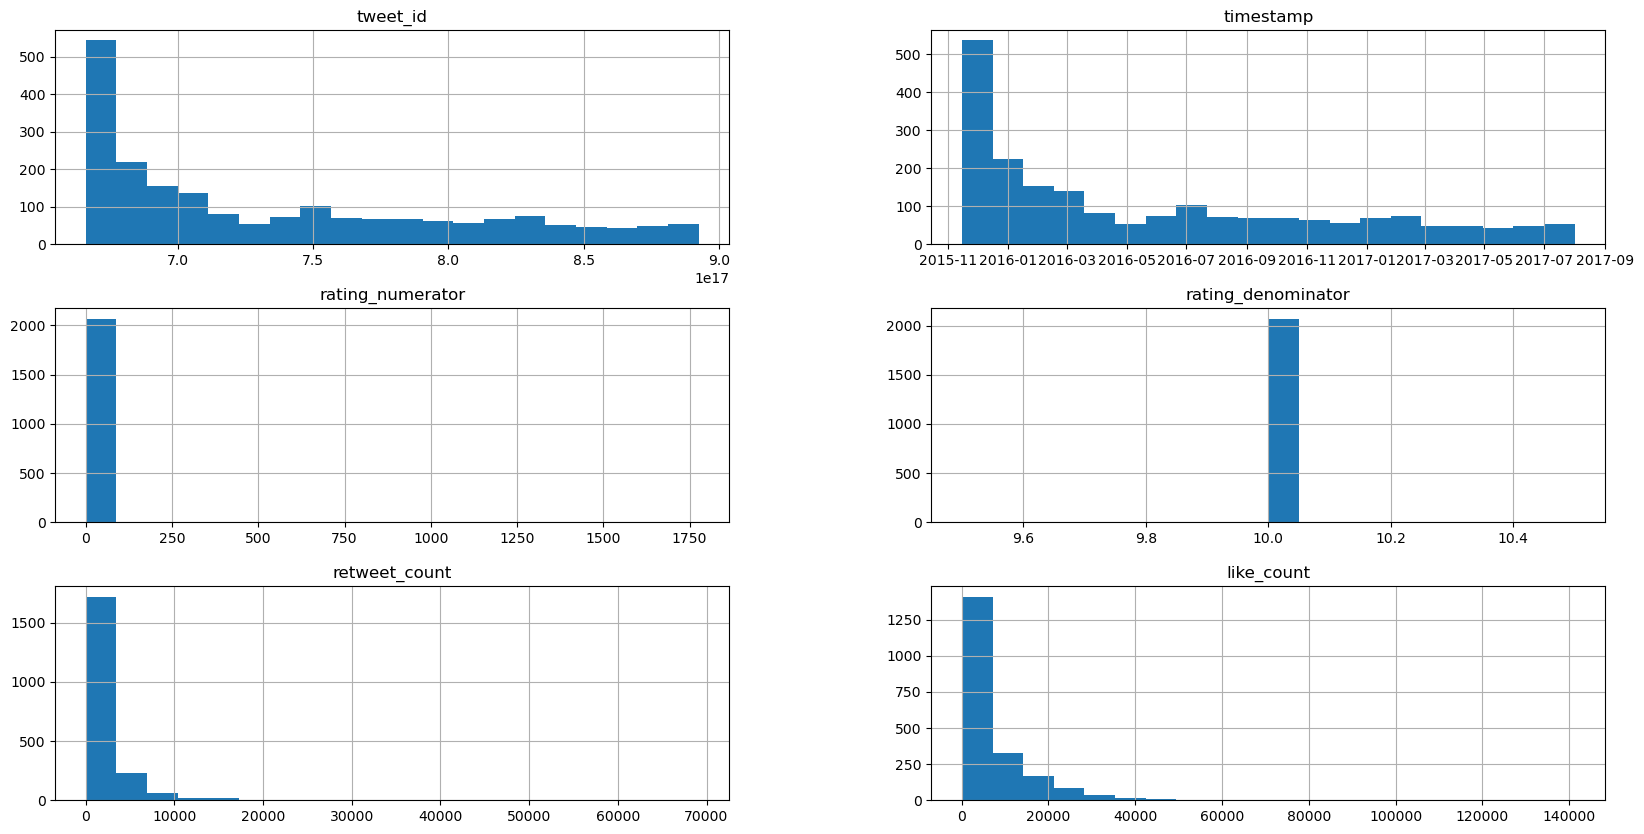

In [102]:
# get a general idea of feature distributions
pd.plotting.hist_frame(df_twitter_master, figsize=(20,10), bins=20);

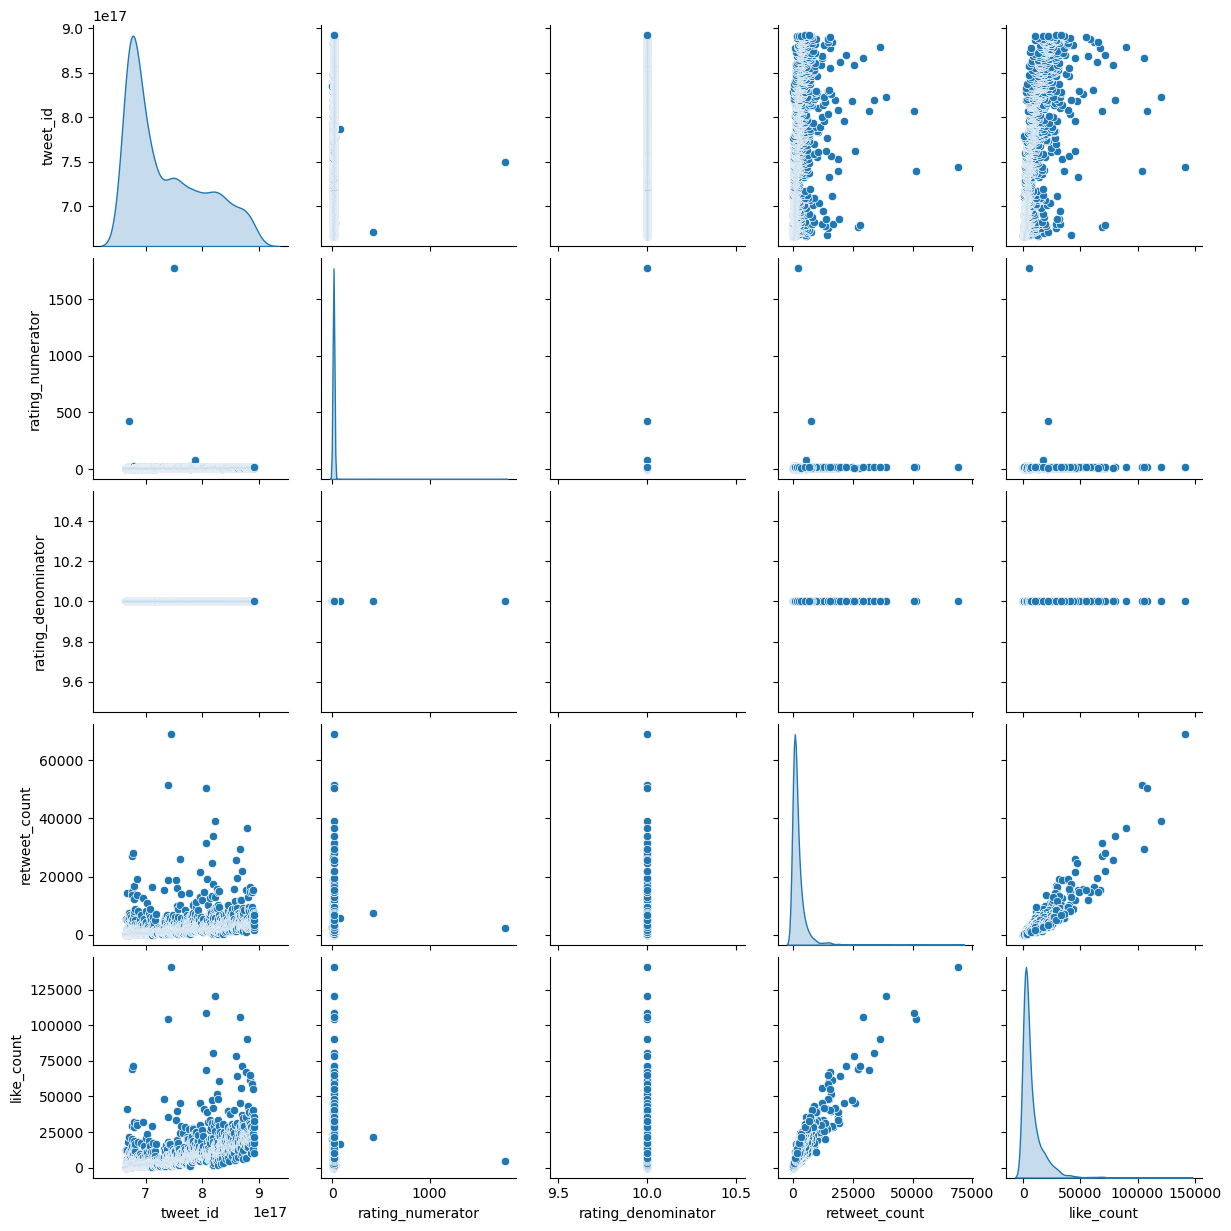

In [103]:
# Let's explore feature distribution and correlations
sns.pairplot(df_twitter_master, kind='scatter', diag_kind='kde');

**Observation from correlations:**

- There is a high correlation between like_count and retweet_count

### Insight questions to answer:

1. Which breeds are tweeted the most ?
2. Which breeds are the post popular ?
3. What is the tweet trent over time ?

Note: Udacity requires only 3 sights to be shared

### Insight 1: Which breeds are tweeted the most by their owners ?

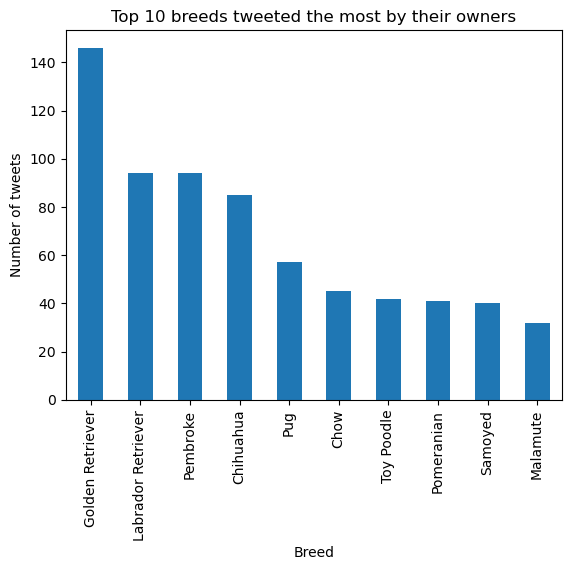

In [104]:
# Display the top 10 breeds that gets tweeted the most
df_twitter_master.breed.value_counts()[:10].plot(kind='bar')
plt.title('Top 10 breeds tweeted the most by their owners')
plt.xlabel('Breed')
plt.ylabel('Number of tweets')
plt.show()

### Insight  2: Which breeds are the post popular ?

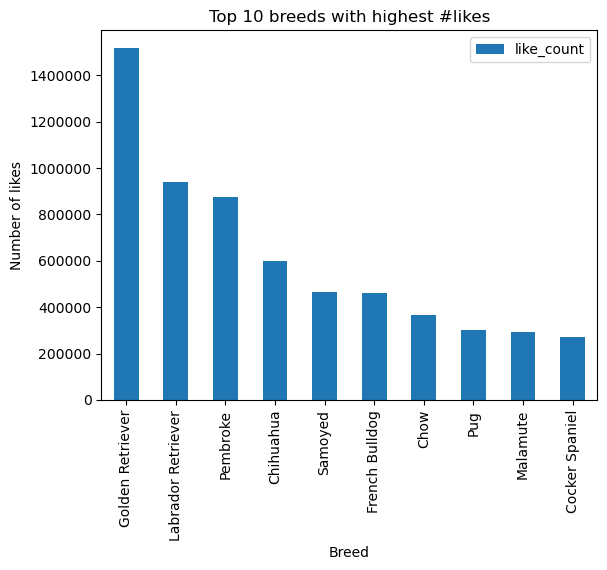

In [105]:
# Display the top 10 breeds with the highest like counts
popular_breeds = df_twitter_master.groupby('breed', as_index=False)['like_count'].sum().sort_values(by='like_count', ascending=False, ignore_index=True)[:10]
ax1 = popular_breeds.plot(kind='bar', x='breed')

# turn off exponential formatting
ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Top 10 breeds with highest #likes')
plt.ylabel('Number of likes')
plt.xlabel('Breed')
plt.show()

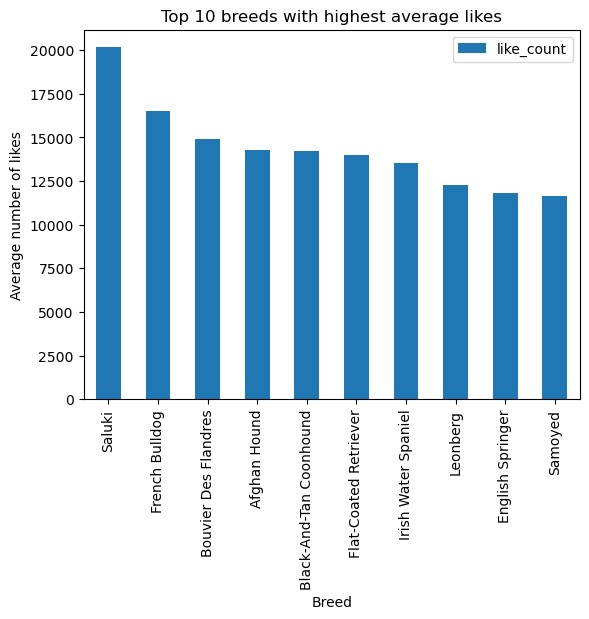

In [106]:
# Display the top 10 breeds with the highest mean counts
popular_breeds = df_twitter_master.groupby('breed', as_index=False)['like_count'].mean().sort_values(by='like_count', ascending=False, ignore_index=True)[:10]
ax1 = popular_breeds.plot(kind='bar', x='breed')

# turn off exponential formatting
ax1.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Top 10 breeds with highest average likes')
plt.ylabel('Average number of likes')
plt.xlabel('Breed')
plt.show()

### Insight 3: What is the tweet trent over time ?

In [107]:
# Create a time series dataset, to track the number of tweets per month
twitter_timeseries = df_twitter_master.filter(['timestamp', 'tweet_id'], axis=1).copy()

# set datetime field as index
twitter_timeseries.set_index('timestamp', inplace=True) 

twitter_timeseries.head()

,tweet_id
timestamp,
2015-11-15,666020888022790149
2015-11-15,666029285002620928
2015-11-15,666033412701032449
2015-11-16,666044226329800704
2015-11-16,666049248165822465


In [108]:
# calculate the mean tweets per month
freq = 'M'
twitter_timeseries = twitter_timeseries.resample(freq).count()
twitter_timeseries

,tweet_id
timestamp,
2015-11-30,295
2015-12-31,369
2016-01-31,181
2016-02-29,119
2016-03-31,129
2016-04-30,58
2016-05-31,58
2016-06-30,89
2016-07-31,94


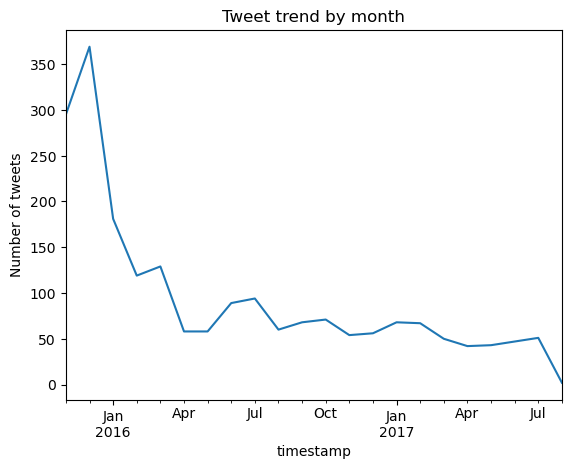

In [109]:
ax = twitter_timeseries.plot()
ax.get_legend().remove()
plt.title('Tweet trend by month')
plt.ylabel('Number of tweets')
plt.show()

### Insights:

**Insight 1: Which breeds are tweeted the most ?**
Owners of Golden Retrievers and Labradors tweet the most

**Insight 2: Which dog breeds are the post popular ?**
Be careful of Simpsons' Paradox, because the owners of labradors tweet the most, they also receive the most total likes. Bedlington Terrier and Saluki dog breeds receive the most average likes per breed

**Insight 3: What is the tweet trent over time ?**
There is downwards trend of number of tweets per month, from Nov 2015 to Oct 2017. The popularity of WeRateDogs seems to decline

### Visualization

Display profiles cards of the dog with the most likes in the top 5 breeds

In [110]:
# Make sure string fields to be used in the profile cards don't contain too much NaN
df_twitter_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2071 non-null   int64         
 1   timestamp           2071 non-null   datetime64[ns]
 2   source              2071 non-null   object        
 3   expanded_urls       2068 non-null   object        
 4   rating_numerator    2071 non-null   int64         
 5   rating_denominator  2071 non-null   int64         
 6   name                1380 non-null   object        
 7   cleantext           2064 non-null   object        
 8   dog_stage           368 non-null    object        
 9   retweet_count       2071 non-null   int64         
 10  like_count          2071 non-null   int64         
 11  media_url           1872 non-null   object        
 12  short_url           2068 non-null   object        
 13  annotation          1567 non-null   object      

In [111]:
# Feature engineering for better visualization
# Convert None values to 'Unknown' as it looks better on the 'profile' card
df_twitter_master['name'] = df_twitter_master['name'].fillna('unknown')
df_twitter_master['breed'] = df_twitter_master['breed'].fillna('unknown')
df_twitter_master['dog_stage'] = df_twitter_master['dog_stage'].fillna('unknown')
df_twitter_master['annotation'] = df_twitter_master['annotation'].fillna('')

In [112]:
# Select the most liked dog in the top average liked breeds
for breed in popular_breeds['breed'][:5]:

    # Select the most popular dog within the selected breed
    idx = df_twitter_master.query('breed == @breed')['like_count'].idxmax()
    best = df_twitter_master.loc[idx]

    display_image(best)

In [113]:
# just for fun, display the dog with the most tweets
idx = df_twitter_master.like_count.idxmax()
best = df_twitter_master.loc[idx]
display_image(best)

<a id='references'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">References</span>

- [Font color in headings](https://stackoverflow.com/questions/4182554/html-css-font-color-vs-span-style)
- [Twitter documentation for get_tweets using V2](https://developer.twitter.com/en/docs/twitter-api/tweets/lookup/api-reference/get-tweets-id)
- [Twitter source code example for get_tweets using V2](https://github.com/twitterdev/Twitter-API-v2-sample-code/blob/main/Tweet-Lookup/get_tweets_with_bearer_token.py)
- [reading a json file](https://knowledge.udacity.com/questions/66949#66975)
- [Twitter API v2, tweepy and pandas in Python](https://www.kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/)
- [How to handle dog stages](https://knowledge.udacity.com/questions/196883)
- [prevent exponential format when plotting](https://stackoverflow.com/questions/14711655/how-to-prevent-numbers-being-changed-to-exponential-form-in-a-plot)
- [How to display images and text together using HTML](https://stackoverflow.com/questions/25698448/how-to-embed-html-into-ipython-output)

<a id='submission'></a>
<span style="color:blue; font-size:30px; line-height:40px; font-family: Calibri;">Submission</span>

In [114]:
# convert notebook to html
os.system('jupyter nbconvert --to html wrangle_act.ipynb')

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook wrangle_act.ipynb to html
[NbConvertApp] Writing 1092853 bytes to wrangle_act.html


0